### Question 2:
Briefly describe how gradient boosting differs from bagging. Implement gradient boosting as invoked in scikit-learn, and evaluate classifier accuracy for the Titanic dataset

Briefly describe how gradient boosting differs from bagging as following.
1. Gradient Boosting 
 - Gradient Boosting is a way of combining predictions that belong to the different types, such as combine sereral weak learners into a stronger learner and is used to reduce bias and variance.
 - Every new subsets contains the elements that were misclassified by previous models.New models are influenced by performance of previously built models.
 - Aim to decrease bias, not variance.
2. Bagging
 - Bagging is a simplest way of combining predicitions that belong to the same types and it is used when the goal is to reduce the variance of a decision tree classifier.
 - Different training data subsets are randomly drawn with replacement from the entire training dataset.Each collection of subset data is used to train their decision trees. Each model is built independently.
 - Aim to decrease variance, and try to sovle over-fitting problem.

In [629]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,matthews_corrcoef,f1_score,classification_report,roc_curve,roc_auc_score,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pandas.api.types import is_string_dtype,is_numeric_dtype
%matplotlib inline

In [630]:
#Reading data from local
if os.path.isfile("./YongjiShen_Titanic_FullList.csv"):
    my_full_df = pd.read_csv("./YongjiShen_Titanic_FullList.csv")
else:
    print("Not Found")

In [631]:
#Dropping meaningless columns
my_full_df = my_full_df.drop(["PassengerId","Name","Cabin","Ticket"],axis = 1)

In [632]:
my_full_df.shape

(1309, 8)

In [633]:
my_full_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [634]:
my_full_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

In [635]:
# # imputation 
# sex = {"male":0,"female":1}

# embarked = {"S":0,"C":1,"Q":2}

# AvgAge_Pclass = [my_full_df[my_full_df["Pclass"] == 1]["Age"].mean(),
#                   my_full_df[my_full_df["Pclass"] == 2]["Age"].mean(),
#                   my_full_df[my_full_df["Pclass"] == 3]["Age"].mean()]

# AvgFare_Pclass = [my_full_df[my_full_df["Pclass"] == 1]["Fare"].mean(),
#                   my_full_df[my_full_df["Pclass"] == 2]["Fare"].mean(),
#                   my_full_df[my_full_df["Pclass"] == 3]["Fare"].mean()]

# for i in my_full_df.index:
#     isex = my_full_df.loc[i,'Sex']
#     iembarked = my_full_df.loc[i,"Embarked"]
#     iage = my_full_df.loc[i,"Age"]
#     ifare = my_full_df.loc[i,"Fare"]
#     ipclass = my_full_df.loc[i,"Pclass"]
#     if isex in sex:
#         my_full_df.loc[i,'Sex'] = sex[isex]
#     else:
#         my_full_df.loc[i,'Sex'] = 2
#     if iembarked in embarked:
#         my_full_df.loc[i,"Embarked"] = embarked[iembarked]
#     else:
#         my_full_df.loc[i,"Embarked"] = 3
#     if np.isnan(iage):
#         my_full_df.loc[i,"Age"] = AvgAge_Pclass[(ipclass-1)]
#     if np.isnan(ifare):
#         my_full_df.loc[i,"Fare"] = AvgFare_Pclass[(ipclass-1)]

In [636]:
my_full_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

In [637]:
my_full_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [638]:
#split train set and test set
train = my_full_df[:int(my_full_df.shape[0]*0.7)]
test = my_full_df[int(my_full_df.shape[0]*0.7):]

In [639]:
y_train = train["Survived"]
x_train = train.drop("Survived",axis = 1)
print(x_train.shape,y_train.shape)

(916, 7) (916,)


In [640]:
y_test = test["Survived"]
x_test = test.drop("Survived",axis = 1)
print(x_test.shape,y_test.shape)

(393, 7) (393,)


In [641]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [642]:
x_train = str_to_cat(x_train)

In [643]:
x_test= str_to_cat(x_test)

In [644]:
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [645]:
x_train,my_table= mydf_preprocessor(x_train,null_table = None)

In [646]:
x_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age_na'], dtype='object')

In [647]:
my_table

{'Age': 28.0}

In [648]:
x_test,my_table= mydf_preprocessor(x_test,null_table = my_table)

In [649]:
x_test.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age_na',
       'Fare_na'],
      dtype='object')

In [650]:
x_train=x_train.drop(["Age_na"],axis = 1)
x_test=x_test.drop(["Age_na","Fare_na"],axis = 1)

In [651]:
x_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [652]:
x_test.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [653]:
x_train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [654]:
x_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [655]:
#Transfrom features by scaling each feature to a given range
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [656]:
#train set and validation set
x_tra,x_val,y_tra,y_val = train_test_split(x_train,y_train,train_size=0.7,random_state=0)

In [657]:
#7 models based on different learning rate
learning_rates = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in learning_rates:
    gb_model = GradientBoostingClassifier(n_estimators=50, learning_rate=learning_rate, max_features=2, max_depth=2, 
                                        random_state=0)
    gb_model.fit(x_tra, y_tra)
    
    print("Learning rate: ", learning_rate)
    print("Training Accuracy Score: ",str(gb_model.score(x_train, y_train)))
    print("Validation Accuracy Score: ",str(gb_model.score(x_val, y_val)))

Learning rate:  0.05
Training Accuracy Score:  0.8067685589519651
Validation Accuracy Score:  0.7781818181818182
Learning rate:  0.075
Training Accuracy Score:  0.8078602620087336
Validation Accuracy Score:  0.7818181818181819
Learning rate:  0.1
Training Accuracy Score:  0.8155021834061136
Validation Accuracy Score:  0.7854545454545454
Learning rate:  0.25
Training Accuracy Score:  0.8318777292576419
Validation Accuracy Score:  0.8072727272727273
Learning rate:  0.5
Training Accuracy Score:  0.8438864628820961
Validation Accuracy Score:  0.7890909090909091
Learning rate:  0.75
Training Accuracy Score:  0.8558951965065502
Validation Accuracy Score:  0.8072727272727273
Learning rate:  1
Training Accuracy Score:  0.861353711790393
Validation Accuracy Score:  0.8072727272727273


In [658]:
#when learning rate = 0.75, model has best accuracy.
#create a new model with learning rate is 0.75
gb_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_features=2, max_depth=2, 
                                        random_state=0)
gb_model.fit(x_train, y_train)
y_pred = gb_model.predict(x_test)

In [659]:
#check the accuracy of the prediction
print(accuracy_score(y_pred,y_test))
print(classification_report(y_pred,y_test))

0.5012722646310432
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       251
           1       0.32      0.34      0.33       142

    accuracy                           0.50       393
   macro avg       0.47      0.47      0.47       393
weighted avg       0.51      0.50      0.50       393



Text(50.99999999999999, 0.5, 'Predicted')

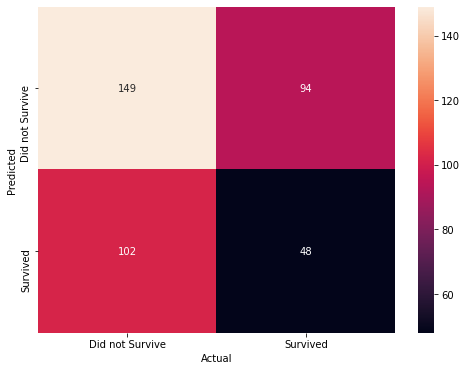

In [660]:
c_mat = confusion_matrix(y_pred,y_test)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

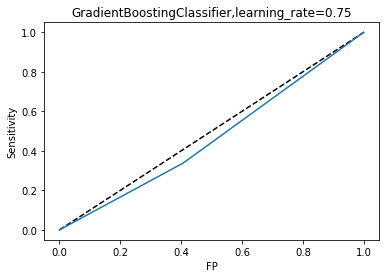

In [661]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('GradientBoostingClassifier,learning_rate=0.25')
plt.show()